In [8]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import pickle, sys, os
import pandas as pd
pd.set_option('display.max_columns', None)

import astropy.units as u
from astropy.coordinates import SkyCoord
from regions import PointSkyRegion

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from gammapy.modeling.models import create_crab_spectral_model, SkyModel, LogParabolaSpectralModel
from gammapy.estimators      import FluxPointsEstimator, LightCurveEstimator
from gammapy.datasets        import Datasets, SpectrumDataset
from gammapy.modeling        import Fit
from gammapy.makers          import SpectrumDatasetMaker, WobbleRegionsFinder, ReflectedRegionsBackgroundMaker, SafeMaskMaker
from gammapy.maps            import MapAxis, RegionGeom, Map
from gammapy.data            import DataStore

# import scripts
sys.path.insert(0, os.path.join("/fefs/aswg/workspace/juan.jimenez/lst1_systematics/scripts"))
import auxiliar as aux

# dl3 path where dl3 and index files are
dl3_dir = "/fefs/aswg/workspace/juan.jimenez/data/lst1_systematics/dl3"
# dl3_dir = "/fefs/aswg/workspace/daniel.morcuende/data/real/DL3/Crab_performance/AllSkyMC_v0.9.9/intensity80/all_nodes/gh_eff_0.7_th_cont_0.7"

# use from coordinates (use astropy units) or from name
target_ra  = None
target_dec = None
target_name = "Crab"

# select he number of off regions
n_off_regions = 3

# energy edges for spectrum
e_min = 80 * u.GeV
e_max = 20 * u.TeV

# energy edges for lightcurve
e_lc_min = 100 * u.GeV
e_lc_max = 100 * u.TeV

In [9]:
data_store = DataStore.from_dir(dl3_dir)

obs_ids = data_store.obs_table["OBS_ID"].data
obs_ids = obs_ids[:4]

observations = data_store.get_observations(obs_ids, required_irf="point-like")

if target_ra == None and target_dec == None and target_name != None:
    target_position = SkyCoord.from_name(target_name)
elif target_ra != None and target_dec != None and target_name == None:
    target_position = SkyCoord(ra=target_ra, dec=target_dec, frame="icrs")
else:
    print("Error defining the coordinate, check input")

on_region = PointSkyRegion(target_position)

data_store.obs_table[:5]

OBS_ID,DATE-OBS,TIME-OBS,DATE-END,TIME-END,RA_PNT,DEC_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,RA_OBJ,DEC_OBJ,TSTART,TSTOP,ONTIME,TELAPSE,LIVETIME,DEADC,OBJECT,OBS_MODE,N_TELS,TELLIST,INSTRUME
,,,,,deg,deg,deg,deg,deg,deg,deg,s,s,s,s,s,,,,,,
int64,bytes10,bytes12,bytes10,bytes12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes4,bytes6,int64,bytes5,bytes5
2914,2020-11-18,03:43:34.195,2020-11-18,04:02:52.571,83.28333273835389,21.78656763343963,14.834757361817395,75.1652426381826,245.1213982356058,83.6333,22.0133,67319014.19521403,67320172.57145381,1158.378688097,1158.376239776611,1110.755623268583,0.9588881724795433,Crab,WOBBLE,1,LST-1,LST-1
2929,2020-11-19,01:41:13.093,2020-11-19,01:59:21.728,83.97361145717055,22.24478469670363,15.850059219741198,74.1499407802588,110.6998555539493,83.6333,22.0133,67398073.09261274,67399161.72822142,1088.646086215973,1088.635608673096,1006.045014654632,0.9241249542829353,Crab,WOBBLE,1,LST-1,LST-1
2930,2020-11-19,02:02:55.113,2020-11-19,02:22:43.852,83.26877566296331,21.78654579520127,11.226227577683517,78.77377242231648,126.6148226222098,83.6333,22.0133,67399375.11288929,67400563.85175204,1187.748401165009,1188.738862752914,1107.370648277967,0.9323276269551675,Crab,WOBBLE,1,LST-1,LST-1
2931,2020-11-19,02:24:41.948,2020-11-19,02:44:15.861,83.97560985781382,22.24446090923748,7.969627275844147,82.03037272415585,144.9893063586275,83.6333,22.0133,67400681.94754553,67401855.8605578,1172.932846069336,1173.913012266159,1097.560117693711,0.9357399457025957,Crab,WOBBLE,1,LST-1,LST-1
2932,2020-11-19,02:46:09.185,2020-11-19,03:05:51.188,83.27280949215712,21.77667796720452,7.156553807764496,82.8434461922355,188.5136819780338,83.6333,22.0133,67401969.18531418,67403151.18843389,1181.100458621979,1182.003119707108,1102.793449016734,0.9336999583451118,Crab,WOBBLE,1,LST-1,LST-1


In [10]:
# true and estimated energy axes
energy_axis      = MapAxis.from_energy_bounds(50, 1e5, nbin=5,  per_decade=True, unit="GeV", name="energy")
energy_axis_true = MapAxis.from_energy_bounds(10, 1e5, nbin=10, per_decade=True, unit="GeV", name="energy_true")

# geometry defining the ON region and SpectrumDataset based on it
geom = RegionGeom.create(region=on_region, axes=[energy_axis])
# creating an empty dataset
dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

In [11]:
dataset_maker = SpectrumDatasetMaker(
    containment_correction=False, selection=["counts", "exposure", "edisp"]
)

# tell the background maker to use the WobbleRegionsFinder, let us use 1 off
region_finder = WobbleRegionsFinder(n_off_regions=n_off_regions)
bkg_maker = ReflectedRegionsBackgroundMaker(region_finder=region_finder)

# use the energy threshold specified in the DL3 files
safe_mask_masker = SafeMaskMaker(methods=["aeff-default"])

In [12]:
%%time
datasets = Datasets()

# create a counts map for visualisation later...
counts = Map.create(skydir=target_position, width=3)

for observation in observations:
    dataset = dataset_maker.run(dataset_empty.copy(name=str(observation.obs_id)), observation)
    
    counts.fill_events(observation.events)
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    datasets.append(dataset_on_off)

/home/juan.jimenez/.conda/envs/gammapy-v0.20.1/lib/python3.8/site-packages/gammapy/maps/geom.py:48: RuntimeWarning: invalid value encountered in cast
  p_idx = np.rint(p).astype(int)
No default upper safe energy threshold defined for obs 2914
No default lower safe energy threshold defined for obs 2914
/home/juan.jimenez/.conda/envs/gammapy-v0.20.1/lib/python3.8/site-packages/gammapy/maps/geom.py:48: RuntimeWarning: invalid value encountered in cast
  p_idx = np.rint(p).astype(int)
No default upper safe energy threshold defined for obs 2929
No default lower safe energy threshold defined for obs 2929
/home/juan.jimenez/.conda/envs/gammapy-v0.20.1/lib/python3.8/site-packages/gammapy/maps/geom.py:48: RuntimeWarning: invalid value encountered in cast
  p_idx = np.rint(p).astype(int)
No default upper safe energy threshold defined for obs 2930
No default lower safe energy threshold defined for obs 2930
/home/juan.jimenez/.conda/envs/gammapy-v0.20.1/lib/python3.8/site-packages/gammapy/maps/geo

CPU times: user 3.73 s, sys: 776 ms, total: 4.51 s
Wall time: 9.41 s


In [13]:
# counting in the specified range
for dataset in datasets:
    dataset.mask_fit = dataset.counts.geom.energy_mask(e_min, e_max)

# defining the model we want to fit and the starting values
spectral_model = LogParabolaSpectralModel(
    amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
    alpha=2,
    beta=0.1,
    reference=1 * u.TeV,
)
# we will use the crab model in general
model = SkyModel(spectral_model=spectral_model, name="crab")
datasets.models = [model]

# now we run the fit to extract the parameters of the model
fit = Fit()
result = fit.run(datasets=datasets)

# we make a copy here to compare it later
best_fit_model = model.copy()

datasets.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str4,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
crab,spectral,amplitude,3.2852e-11,cm-2 s-1 TeV-1,1.701e-12,nan,nan,False,True,
crab,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
crab,spectral,alpha,2.4946e+00,,5.512e-02,nan,nan,False,False,
crab,spectral,beta,1.1824e-01,,3.577e-02,nan,nan,False,False,


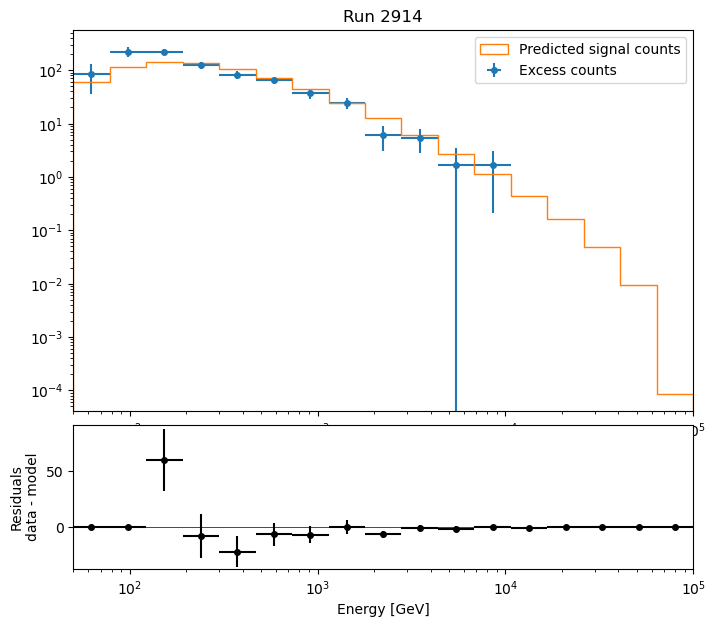

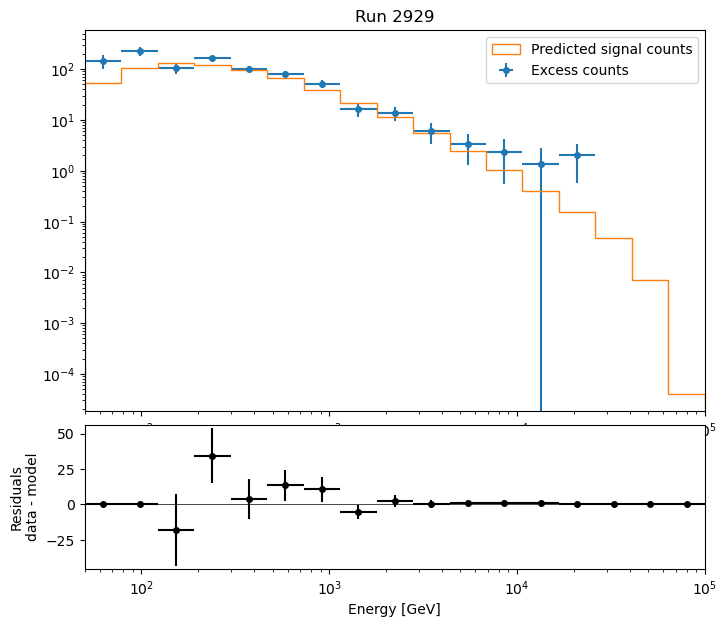

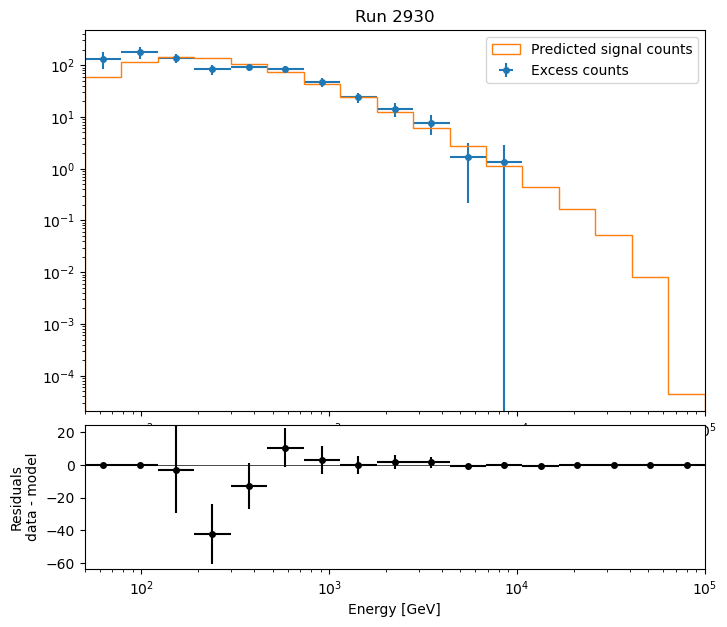

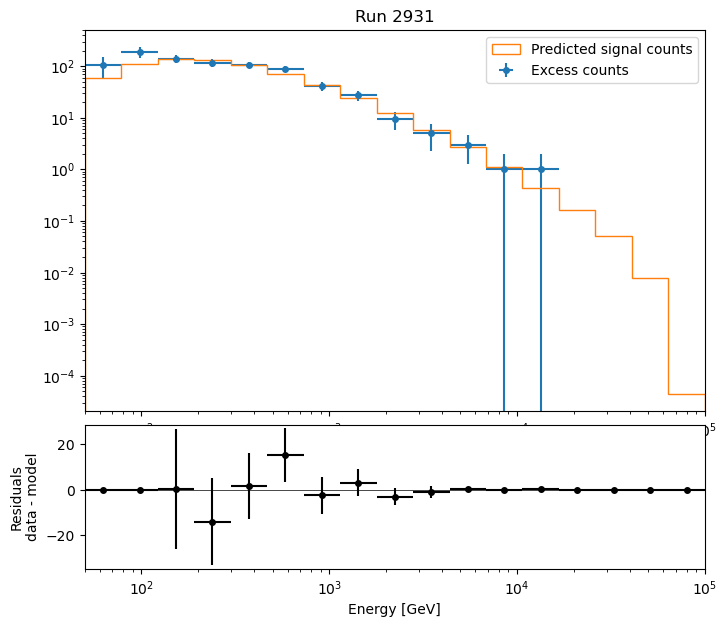

In [14]:
for dataset in datasets:
    ax_spectrum, ax_residuals = dataset.plot_fit()
    ax_spectrum.set_title(f"Run {dataset.name}")
    plt.show()

In [15]:
# creating energy edges
energy_edges = np.geomspace(e_min.to("TeV").value, e_max.to("TeV").value, 11) * u.TeV

# then extracting the flux points from the data
fpe = FluxPointsEstimator(
    energy_edges=energy_edges, source="crab", selection_optional="all"
)
flux_points = fpe.run(datasets=datasets)

flux_points.to_table(sed_type="dnde", formatted=True)

e_ref,e_min,e_max,dnde,dnde_err,dnde_errp,dnde_errn,dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
GeV,GeV,GeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[4],float32[4],float64,bool,float64[4],bool,float64[11],float64[11]
97.777,78.189,122.272,nan,nan,nan,nan,nan,nan,nan,nan .. nan,0.0 .. 0.0,0.000,False,0.0 .. 0.0,False,0.200 .. 5.000,nan .. nan
191.207,122.272,299.008,1.464e-09,8.551e-11,8.589e-11,8.513e-11,1.636e-09,341.297,18.474,867.7763443644486 .. 877.0902798182858,276.25885 .. 272.71442,21.218,False,921.0 .. 865.0,True,0.200 .. 5.000,232.444 .. 2934.876
373.914,299.008,467.586,3.130e-10,2.337e-11,2.359e-11,2.314e-11,3.606e-10,234.016,15.298,172.7527211639157 .. 173.8214755440271,97.7432 .. 96.12049,2.764,False,159.0 .. 183.0,True,0.200 .. 5.000,138.175 .. 1615.723
584.723,467.586,731.205,1.367e-10,9.694e-12,9.822e-12,9.569e-12,1.566e-10,294.440,17.159,109.50886444366695 .. 120.61532853728363,80.77773 .. 80.80282,3.096,False,95.0 .. 128.0,True,0.200 .. 5.000,189.885 .. 1042.809
914.384,731.205,1143.451,4.206e-11,3.942e-12,4.014e-12,3.872e-12,5.025e-11,172.963,13.152,58.39093497732654 .. 62.37145431486729,44.637875 .. 44.362606,2.997,False,51.0 .. 59.0,True,0.200 .. 5.000,106.793 .. 696.663
1429.904,1143.451,1788.117,1.306e-11,1.595e-12,1.639e-12,1.553e-12,1.643e-11,109.200,10.450,33.144361915162534 .. 29.394204863221894,23.730017 .. 23.485949,1.430,False,34.0 .. 33.0,True,0.200 .. 5.000,64.816 .. 411.216
2796.238,1788.117,4372.727,2.043e-12,2.930e-13,3.026e-13,2.837e-13,2.668e-12,81.847,9.047,19.424628482599942 .. 21.300729818390927,16.997871 .. 16.785995,4.645,False,14.0 .. 19.0,True,0.200 .. 5.000,49.441 .. 337.628
5468.163,4372.727,6838.024,3.137e-13,1.121e-13,1.229e-13,1.019e-13,5.819e-13,15.402,3.925,3.79064639711073 .. 2.4834858709251373,2.5439882 .. 2.483486,0.878,False,3.0 .. 3.0,True,0.200 .. 5.000,9.564 .. 49.961


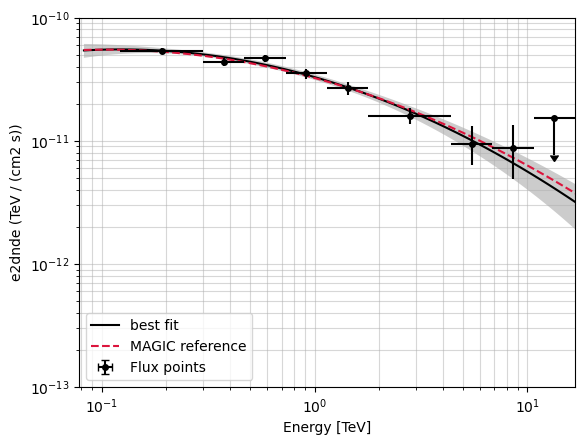

In [16]:
plot_kwargs = {
    "energy_bounds": [0.08, 40] * u.TeV,
    "sed_type": "e2dnde",
    "yunits": u.Unit("TeV cm-2 s-1"),
    "xunits": u.TeV,
}

crab_magic_lp = create_crab_spectral_model("magic_lp")

best_fit_model.spectral_model.plot(
    ls="-", lw=1.5, color="k", label="best fit", **plot_kwargs
)
best_fit_model.spectral_model.plot_error(
    facecolor="k", alpha=0.2, **plot_kwargs
)
crab_magic_lp.plot(
    ls="--", lw=1.5, color="crimson", label="MAGIC reference", **plot_kwargs
)

flux_points.plot(sed_type="e2dnde", color="k", label="Flux points")
# flux_points.plot_ts_profiles(sed_type="e2dnde")

plt.legend(loc=3)
plt.ylim([1e-13, 1e-10])
plt.grid(which="both", alpha=0.5)
plt.show()

# Light Curve

In [17]:
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    LogParabolaSpectralModel,
    create_crab_spectral_model,
    SkyModel,
)
from gammapy.datasets import (
    Datasets,
    FluxPointsDataset,
    SpectrumDataset,
    SpectrumDatasetOnOff,
)
# Find pivot (decorrelation) energy for a Power Law model to get the reference energy for Log Parabola model
def get_pivot_energy(datasets, e_ref, e_edges, obj_name):
    """
    Using Power Law spectral model with the given reference energy and 
    get the decorrelation energy of the fit, within the fit energy range, e_edges.
    This method is further explained in doi:10.1088/0004-637X/707/2/1310
    """
    spectral_model = PowerLawSpectralModel(
        index=2, amplitude=2e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=e_ref
    )
    model = SkyModel(spectral_model=spectral_model, name=obj_name)
    model_check = model.copy()

    # Stacked dataset method
    stacked_dataset = Datasets(datasets).stack_reduce()
    stacked_dataset.models = model_check

    fit_stacked = Fit()
    result_stacked = fit_stacked.run(datasets=stacked_dataset)

    return model_check.spectral_model.pivot_energy

# Using a reference energy close to the expected decorrelation energy
ref = get_pivot_energy(datasets, 0.4 * u.TeV, energy_axis.edges, target_name)
print(f"Reference energy {ref.to_value(u.GeV):.2f} GeV")

Reference energy 345.54 GeV


In [18]:
spectral_model_lp = LogParabolaSpectralModel(
        amplitude = 5e-12 * u.Unit('cm-2 s-1 TeV-1'),
        reference = ref,
        alpha = 2 * u.Unit(''),
        beta = 0.1 * u.Unit('')
)
model_lp = SkyModel(spectral_model=spectral_model_lp, name=target_name)

In [19]:
stacked_dataset = Datasets(datasets).stack_reduce()
stacked_dataset.models = model_lp

# Fitting the model to the dataset
fit = Fit()
result = fit.run(datasets=stacked_dataset)
model_best = model_lp

In [20]:
energy_fit_edges = MapAxis.from_energy_bounds(
    e_lc_min, 
    e_lc_max, 
    nbin=5, 
    per_decade=True, 
    unit="TeV"
).edges

fpe = FluxPointsEstimator(
    energy_edges=energy_fit_edges, 
    reoptimize = False, # Re-optimizing other free model parameters (not belonging to the source)
    source=target_name,
    selection_optional="all" # Estimates asymmetric errors, upper limits and fit statistic profiles
)

flux_points = fpe.run(datasets=stacked_dataset)

flux_points_dataset = FluxPointsDataset(
    data=flux_points, 
    models=model_best
)

In [21]:
lc_maker_1d = LightCurveEstimator(
    energy_edges=[e_lc_min, e_lc_max], 
    reoptimize=False, # Re-optimizing other free model parameters (not belonging to the source)
    source=target_name, 
    selection_optional="all" # Estimates asymmetric errors, upper limits and fit statistic profiles
)

# Assigning the model for each dataset
for data in datasets:
    data.models = model_lp

lc_1d = lc_maker_1d.run(datasets)

# Fitting the model to the dataset
fit = Fit()
result = fit.run(datasets=stacked_dataset)
result

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 37
	total stat : 21.17

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

In [22]:
crab = create_crab_spectral_model("magic_lp")
flux_crab = crab.integral(e_lc_min, e_lc_max)

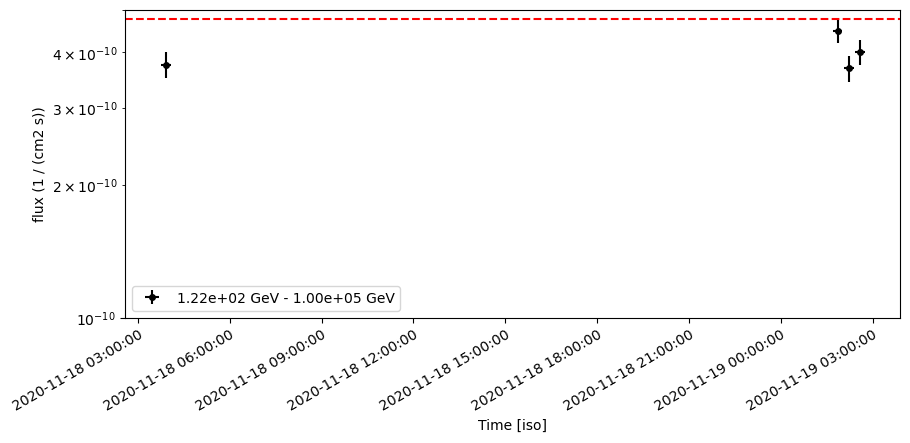

In [23]:
fig, ax = plt.subplots(figsize=(10,4))

lc_1d.plot(sed_type="flux", color="k")
ax.axhline(
    flux_crab.to_value("cm-2 s-1"), c='red', ls='--', 
    label='Crab (MAGIC, JHEAp 2015)'
)

plt.ylim(1e-10, 5e-10)
plt.show()

In [24]:
def unpack(data):
    return np.array([d[0][0][0] for d in data])
    
flux = (unpack(lc_1d.flux.data) * lc_1d.flux.unit).to("TeV / (cm2 s TeV)")
flux_err = (unpack(lc_1d.flux_err.data) * lc_1d.flux_err.unit).to("TeV / (cm2 s TeV)")
run_num = [(n) for n in observations.ids]

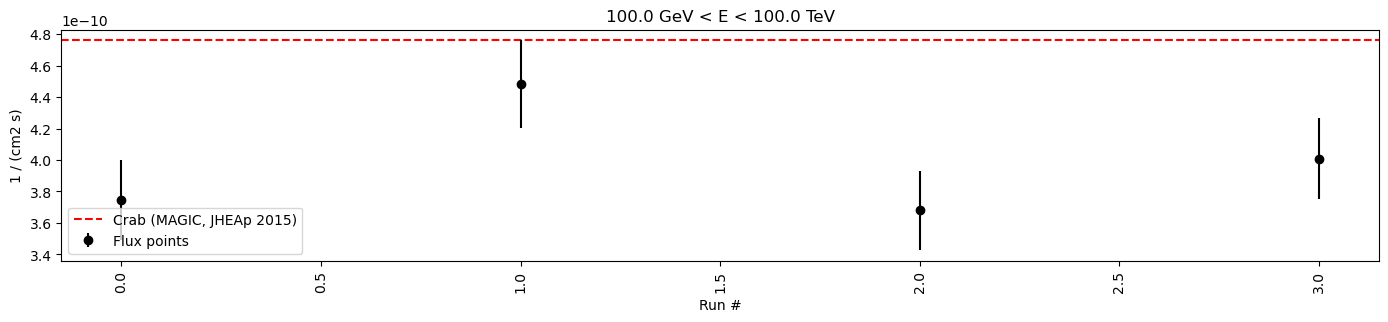

In [25]:
fig, ax = plt.subplots(figsize=(17,3))

ax.axhline(flux_crab.to_value("cm-2 s-1"), c='red', ls='--', label='Crab (MAGIC, JHEAp 2015)')

ax.errorbar(np.arange(len(flux)), flux, yerr=flux_err, ls="", marker="o", color="k", label="Flux points")
# ax.errorbar(run_num, flux, yerr=flux_err, ls="", marker="o", color="k", label="Flux points")
plt.xticks(rotation=90)
ax.legend()
ax.set_xlabel(f"Run #")
ax.set_ylabel(f"{flux.unit}")
ax.set_title(f"{e_lc_min} < E < {e_lc_max}")
plt.show()

In [26]:
dict_LC = {
    "run_number" : run_num,
    "flux" : flux,
    "e_flux" : flux_err,
}

obstable = data_store.obs_table.to_pandas()

In [27]:
time_start, time_stop, timedelta = [], [], []
zd, az = [], []
for run in dict_LC["run_number"]:
    _tab = obstable[obstable["OBS_ID"] == int(run)]
    tstart = datetime.fromisoformat(str(np.array(_tab["DATE-OBS"])[0] + b"T" + np.array(_tab["TIME-OBS"])[0])[2:-1])
    tstop  = datetime.fromisoformat(str(np.array(_tab["DATE-END"])[0] + b"T" + np.array(_tab["TIME-END"])[0])[2:-1])   
    time_start.append(tstart)
    time_stop.append(tstop)
    timedelta.append(tstop - tstart)
    zd.append(np.array(_tab["ZEN_PNT"])[0])
    az.append(np.array(_tab["AZ_PNT"])[0])
    
dict_LC["timestamp"] = np.array(time_start)
dict_LC["duration"]  = np.array(timedelta)
dict_LC["zd"] = np.array(zd) * u.deg
dict_LC["az"] = np.array(az) * u.deg

In [28]:
##################################
# save in a object

# Saving the objects
with open('objects/dict_LC.pkl', 'wb') as f:
    pickle.dump(dict_LC, f, pickle.HIGHEST_PROTOCOL)


In [29]:
# this to read the objects
with open('objects/dict_LC.pkl', 'rb') as f:
    dict_LC = pickle.load(f)